In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Building and Deploying an Agent with Reasoning Engine in Vertex AI

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/reasoning-engine/intro_reasoning_engine.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Freasoning-engine%2Fintro_reasoning_engine.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/reasoning-engine/intro_reasoning_engine.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/reasoning-engine/intro_reasoning_engine.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


| | |
|-|-|
|Author(s) | [Kristopher Overholt](https://github.com/koverholt) |

## Overview

### Gemini

Gemini is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases.

### Function Calling in Gemini

[Function calling](https://cloud.google.com/vertex-ai/docs/generative-ai/multimodal/function-calling) lets developers create a description of a function in their code, then pass that description to a language model in a request. The response from the model includes the name of a function that matches the description and the arguments to call it with.

### Reasoning Engine in Vertex AI

[Reasoning Engine](https://cloud.google.com/vertex-ai/generative-ai/docs/reasoning-engine/overview) (LangChain on Vertex AI) is a managed service that helps you to build and deploy an agent reasoning framework. It gives you the flexibility to choose how much reasoning you want to delegate to the LLM and how much you want to handle with customized code. You can define Python functions that get used as tools via [Gemini Function Calling](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/function-calling). Reasoning Engine integrates closely with the Python SDK for the Gemini model in Vertex AI, and it can manage prompts, agents, and examples in a modular way. Reasoning Engine is compatible with LangChain, LlamaIndex, or other Python frameworks.

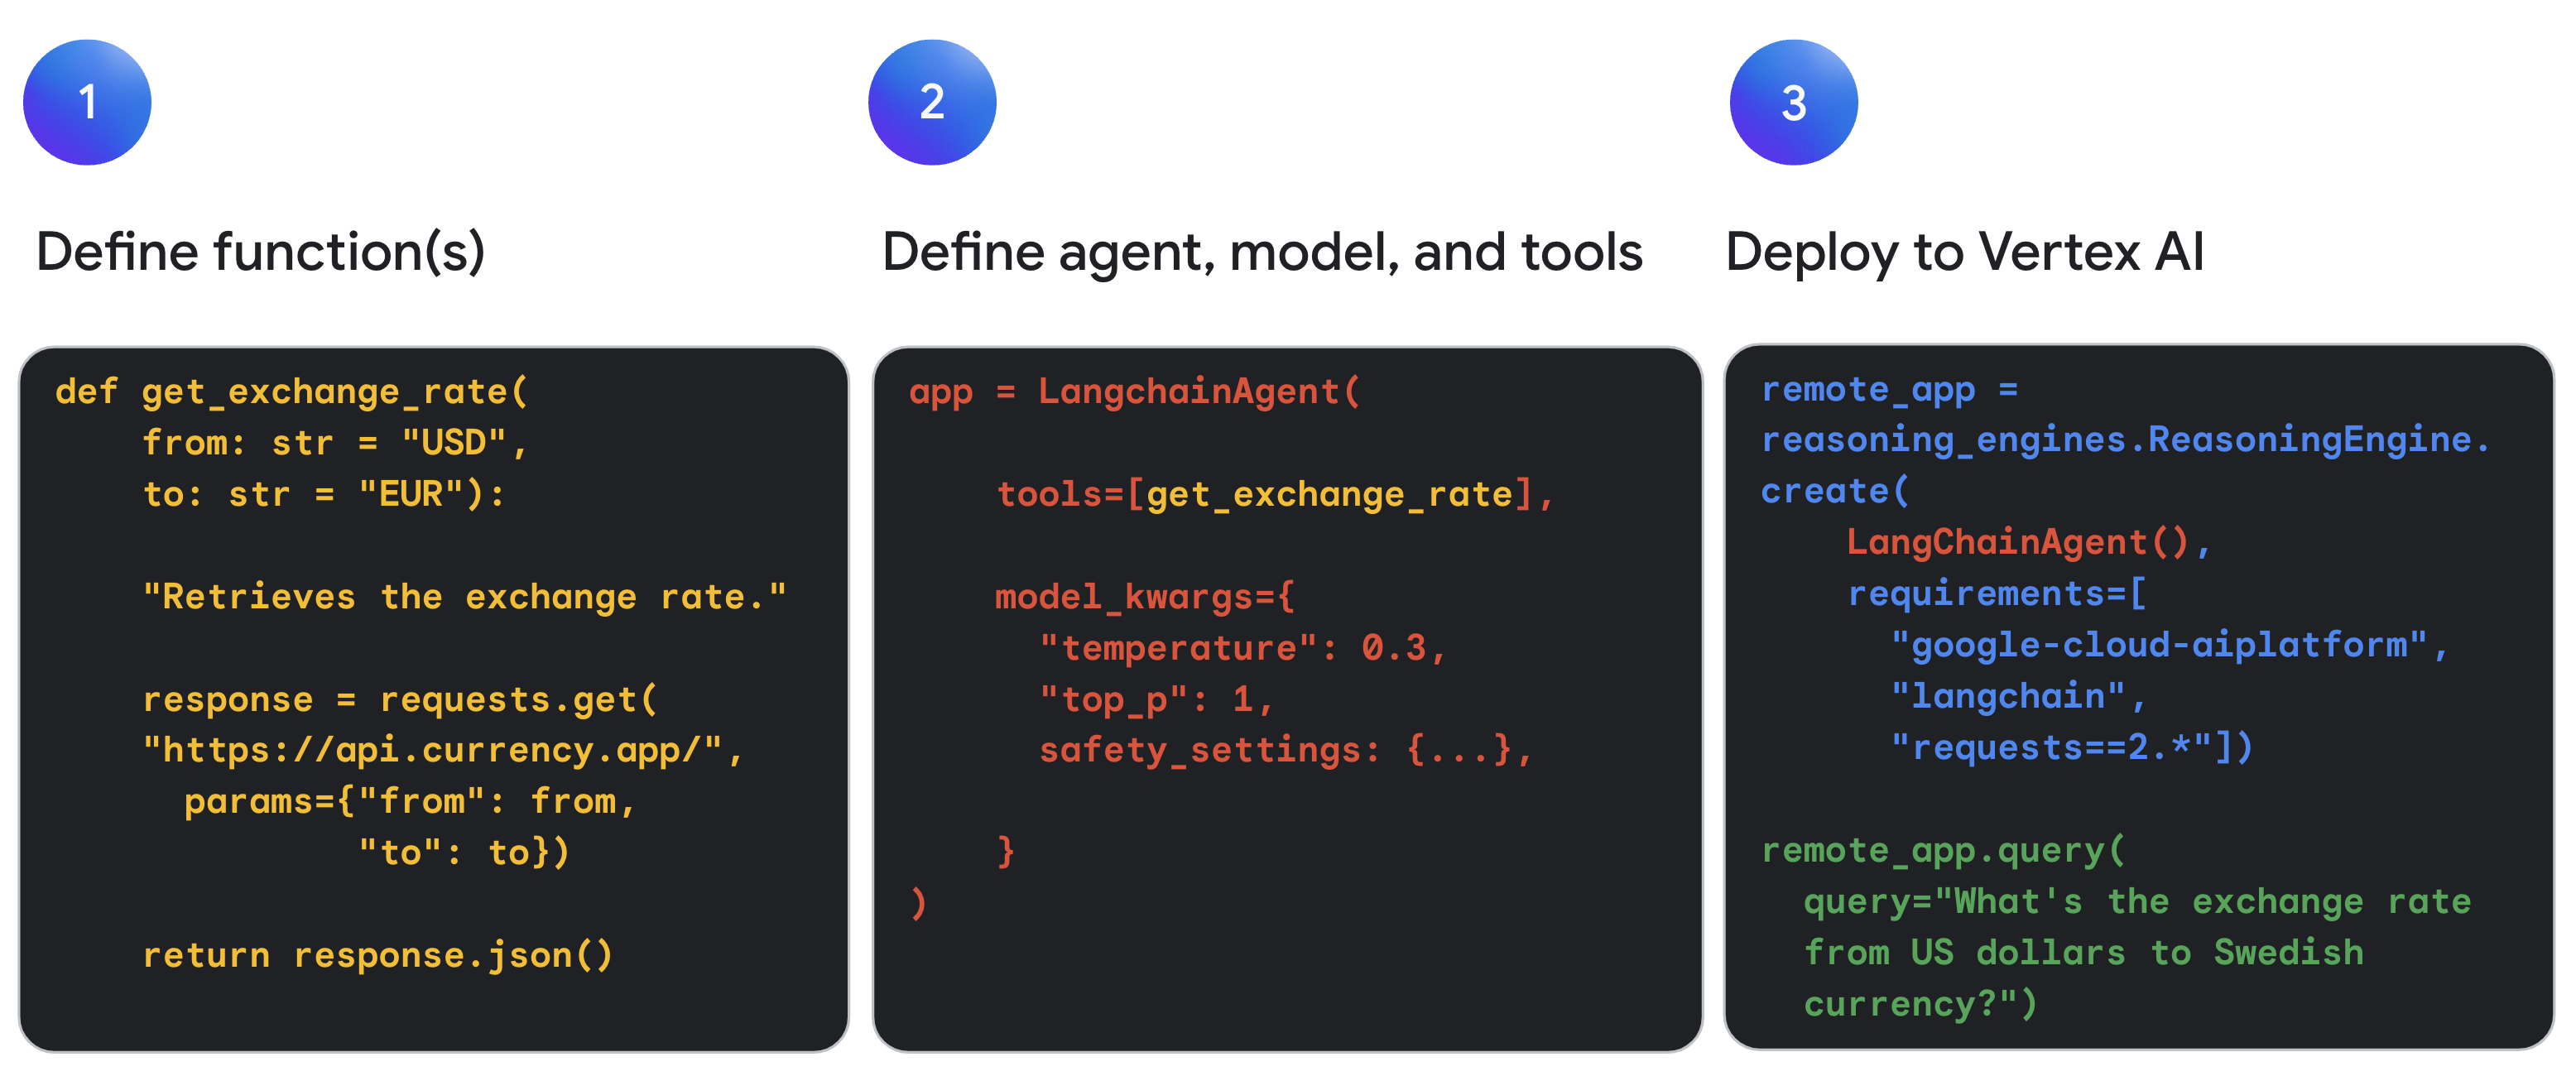

### Objectives

In this tutorial, you will learn how to build and deploy an agent (model, tools, and reasoning) using the Vertex AI SDK for Python.

You'll build and deploy an agent that uses the Gemini Pro model, Python functions as tools, and LangChain for orchestration.

You will complete the following tasks:

- Install the Vertex AI SDK for Python
- Use the Vertex AI SDK to build components of a simple agent
- Test your agent locally before deploying
- Deploy and test your agent on Vertex AI
- Customize each layer of your agent (model, tools, orchestration)

### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## Getting Started


### Install Vertex AI SDK for Python

Install the latest version of the Vertex AI SDK for Python as well as extra dependencies related to Reasoning Engine and LangChain:

In [ ]:
!pip install --upgrade "google-cloud-aiplatform[reasoningengine,langchain]"

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [1]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [2]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
STAGING_BUCKET = "gs://[your-bucket-name]"  # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION, staging_bucket=STAGING_BUCKET)

## Example: Build and deploy an agent

### Import libraries

In [3]:
import requests
from vertexai.preview import reasoning_engines

### Define model

As you construct your agent from the bottom up, the first component deals with which generative model you want to use in your agent.

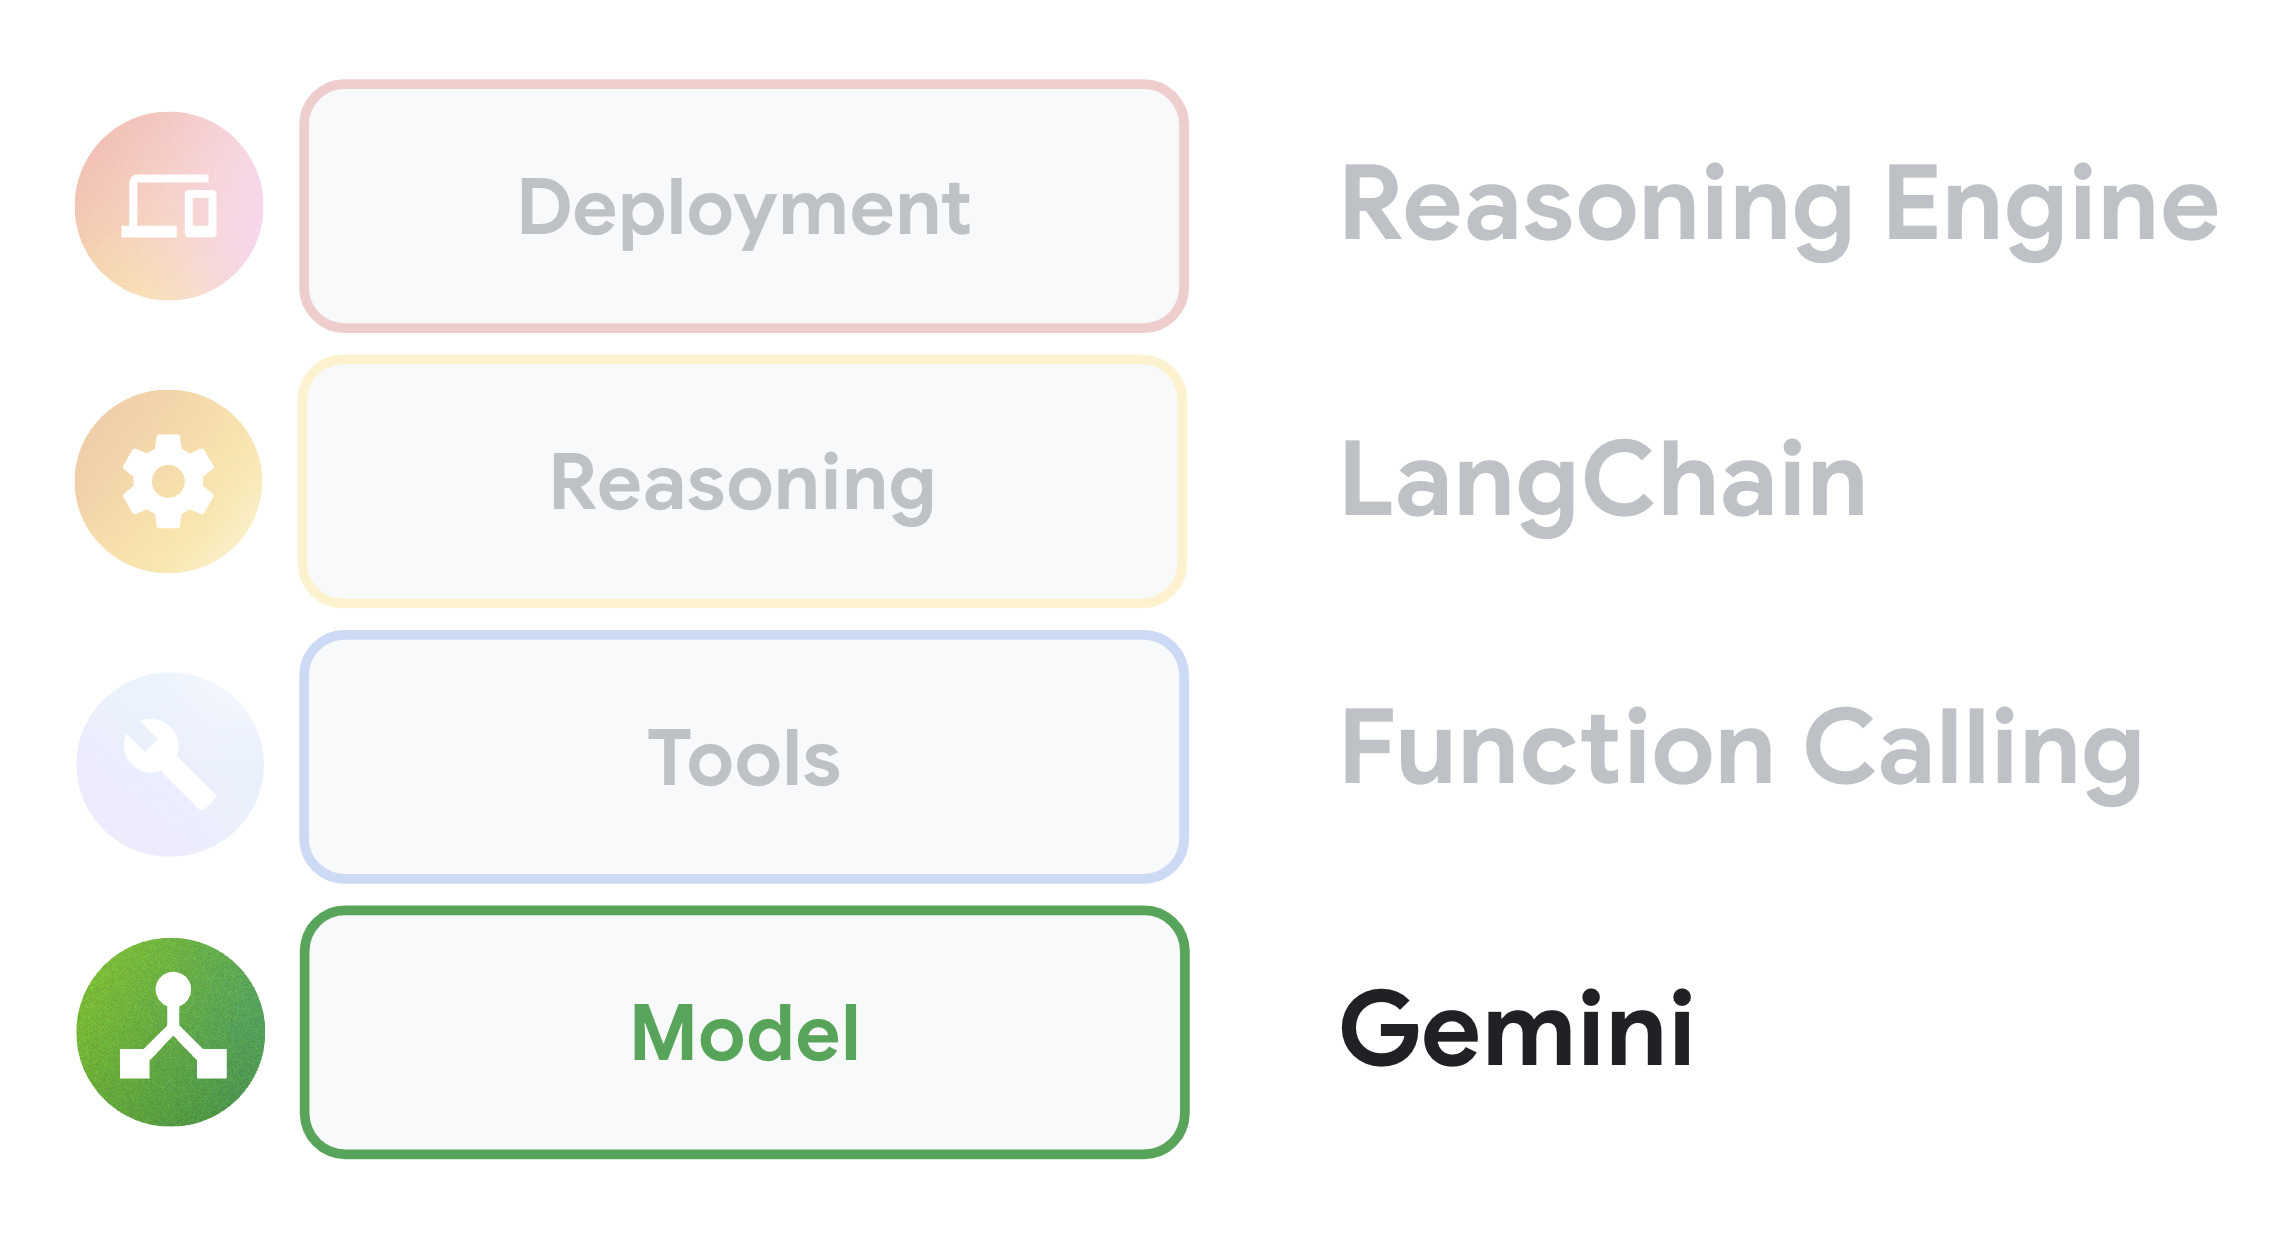

Here you'll use the Gemini 1.5 Pro model:

In [4]:
model = "gemini-1.5-pro-preview-0409"

### Define Python functions (tools)

The second component of your agent includes tools and functions, which enable the generative model to interact with external systems, databases, document stores, and other APIs so that the model can get the most up-to-date information or take action with those systems.

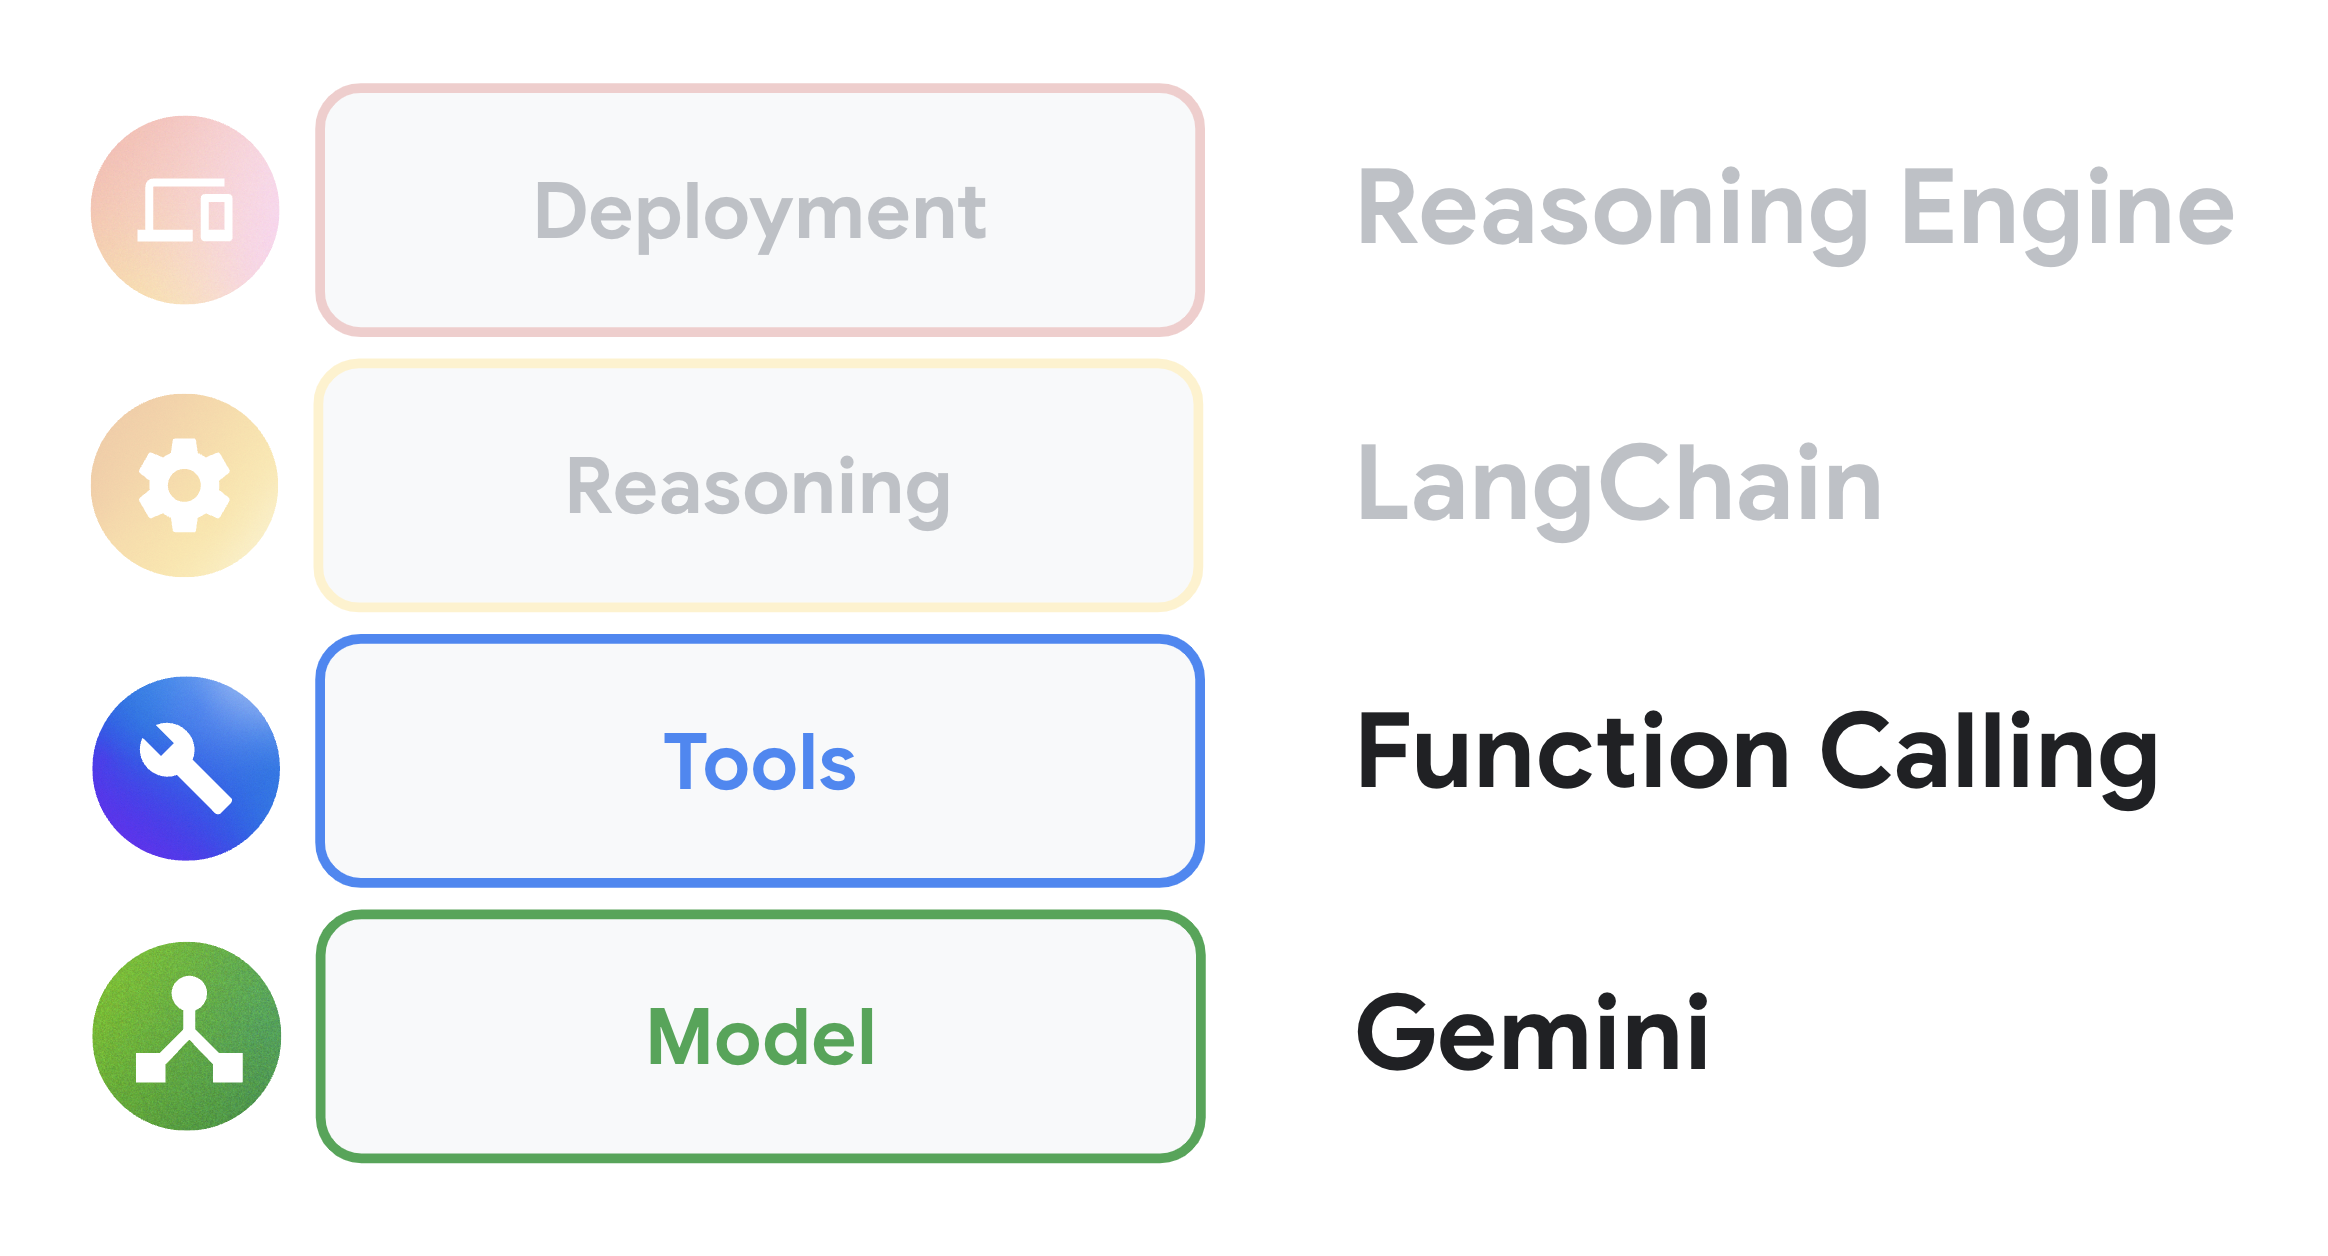

In this example, you'll define a function called `get_exchange_rate` that uses the `requests` library to retrieve real-time currency exchange information from an API:

In [5]:
def get_exchange_rate(
    currency_from: str = "USD",
    currency_to: str = "EUR",
    currency_date: str = "latest",
):
    """Retrieves the exchange rate between two currencies on a specified date."""
    import requests

    response = requests.get(
        f"https://api.frankfurter.app/{currency_date}",
        params={"from": currency_from, "to": currency_to},
    )
    return response.json()

Test the function with sample inputs to ensure that it's working as expected:

In [6]:
get_exchange_rate(currency_from="USD", currency_to="SEK")

{'amount': 1.0, 'base': 'USD', 'date': '2024-04-19', 'rates': {'SEK': 10.949}}

### Define agent

The third component of your agent involves adding a reasoning layer, which helps your agent use the tools that you provided to help the end user achieve a higher-level goal.

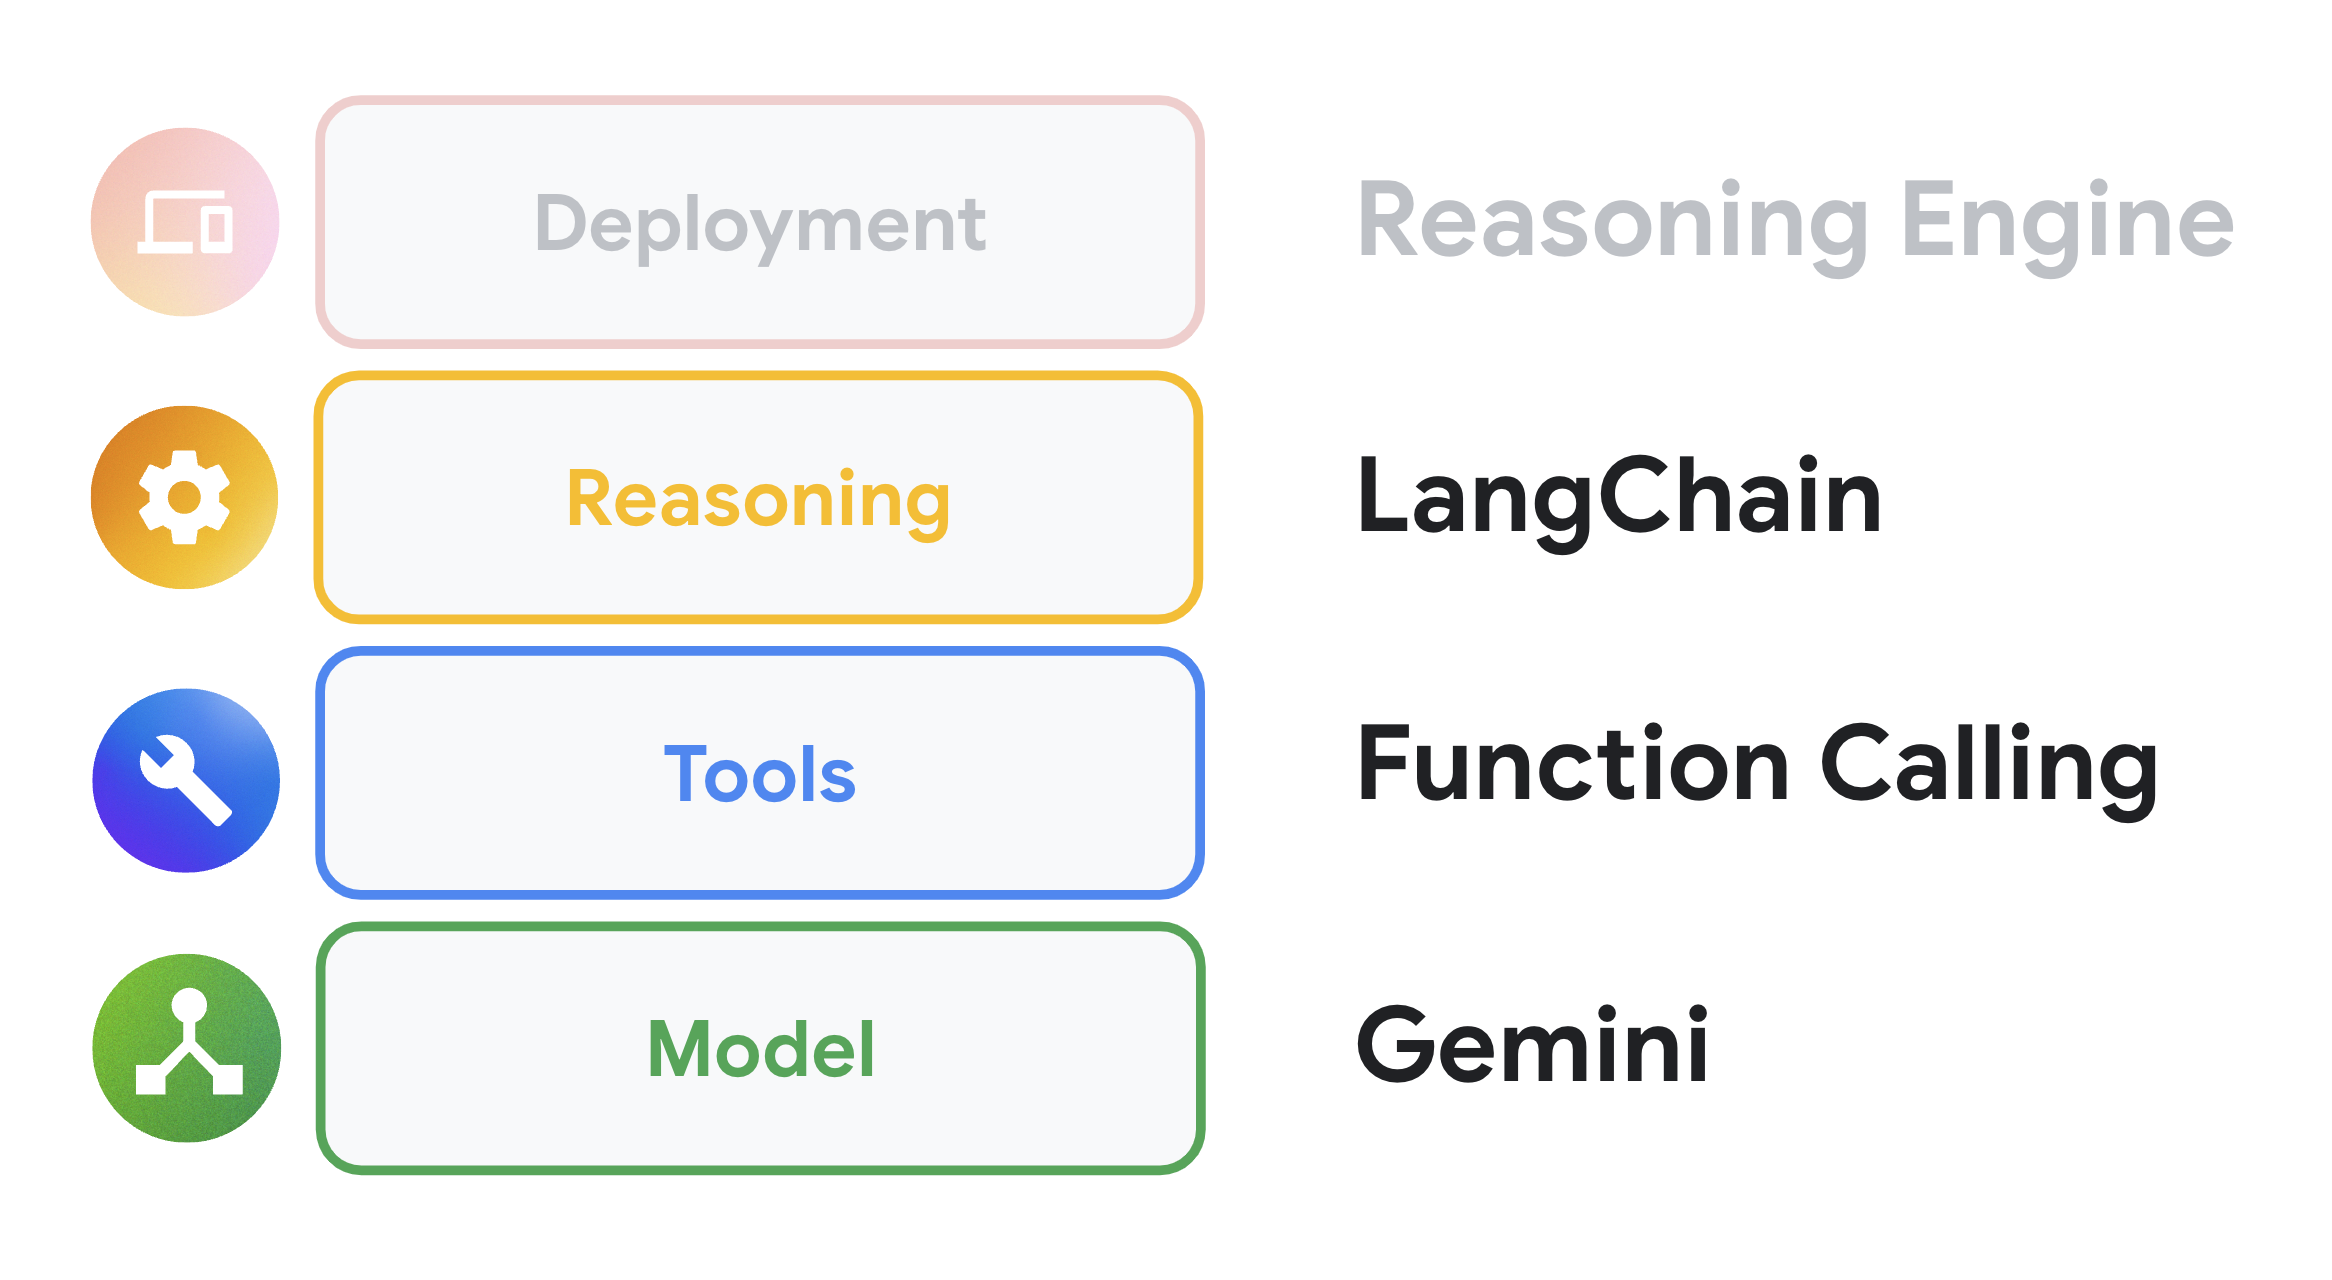

If you were to use Gemini and Function Calling on their own without a reasoning layer, you would need to handle the process of calling functions and APIs in your application code, and you would need to implement retries and additional logic to ensure that your function calling code is resilient to failures and malformed requests.

Here, you'll use the LangChain agent template provided in the Vertex AI SDK for Reasoning Engine, which brings together the model, tools, and reasoning that you've built up so far:

In [7]:
agent = reasoning_engines.LangchainAgent(
    model=model,
    tools=[get_exchange_rate],
    agent_executor_kwargs={"return_intermediate_steps": True},
)

Now we can test the model and agent behavior to ensure that it's working as expected before we deploy it:

### Test your agent locally

With all of the core components of your agent in place, you can send a prompt to your agent to test that it's working as expected, including the intermediate steps that the agent performed between the input prompt and the generated summary output:

In [8]:
agent.query(input="What's the exchange rate from US dollars to Swedish currency today?")

{'input': "What's the exchange rate from US dollars to Swedish currency today?",
 'output': 'Today, 1 US dollar is equal to 10.949 Swedish krona. \n',
 'intermediate_steps': [(AgentActionMessageLog(tool='get_exchange_rate', tool_input={'currency_from': 'USD', 'currency_to': 'SEK'}, log="\nInvoking: `get_exchange_rate` with `{'currency_from': 'USD', 'currency_to': 'SEK'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'function_call': {'name': 'get_exchange_rate', 'arguments': '{"currency_from": "USD", "currency_to": "SEK"}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability_label': 'NEGLIGIBLE', 'blocked': F

### Deploy your agent on Vertex AI

Now that you've specified a model, tools, and reasoning for your agent and tested it out, you're ready to deploy your agent as a remote service in Vertex AI!

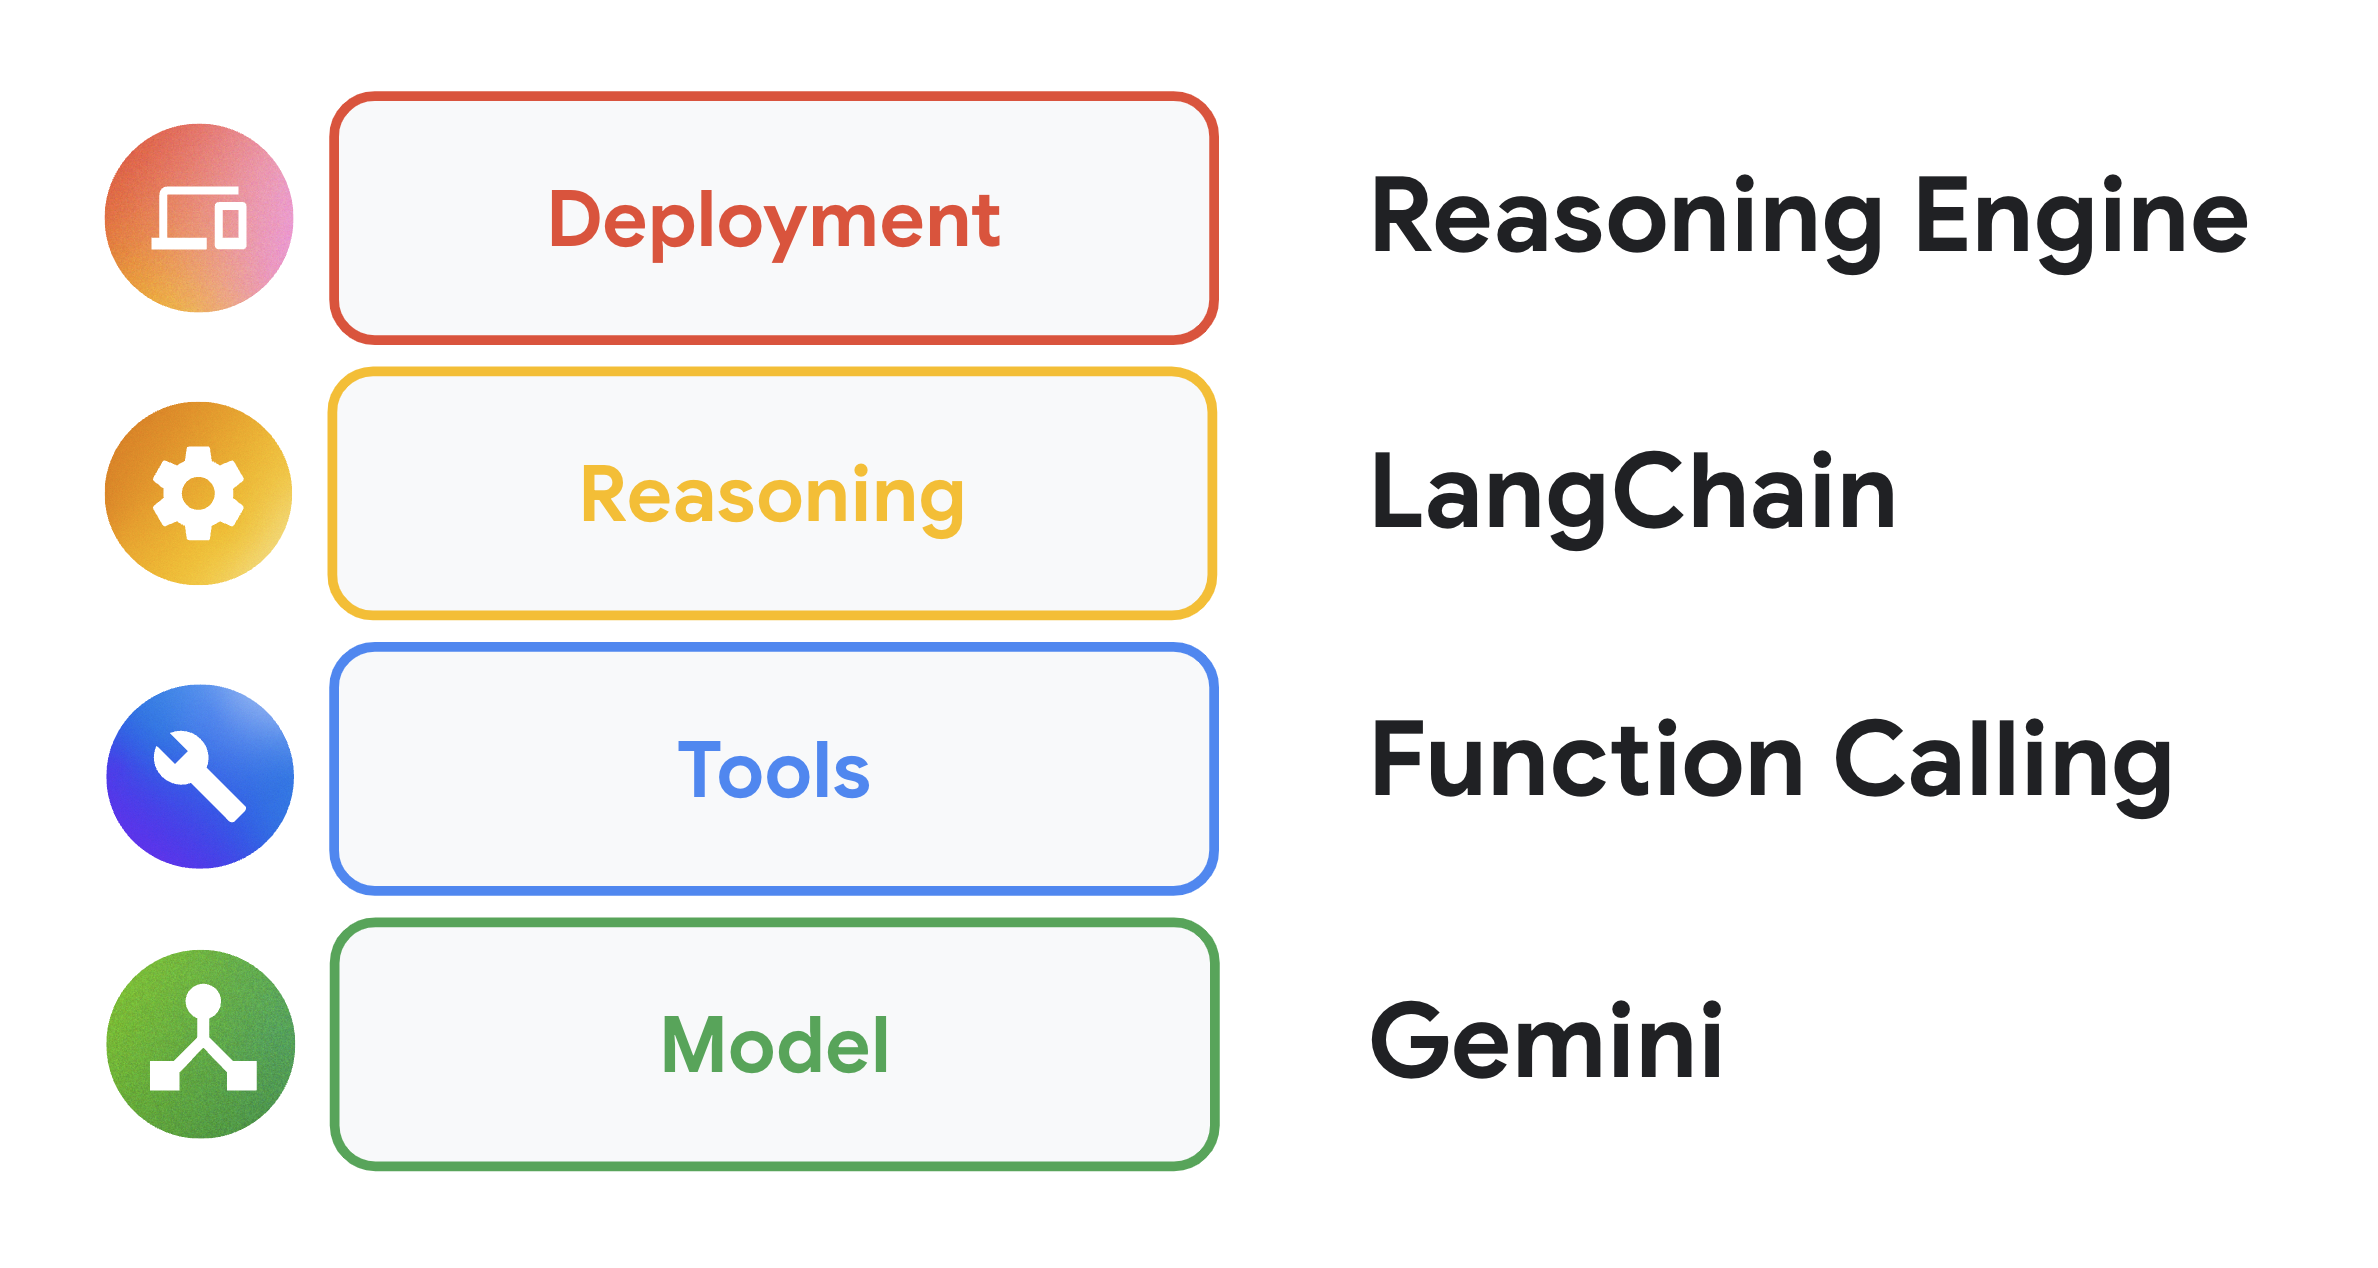

You can re-define the agent to avoid any stateful information in the agent due to our testing in the previous cell:

In [9]:
agent = reasoning_engines.LangchainAgent(
    model=model,
    tools=[get_exchange_rate],
)

Now you're ready to deploy your agent to Reasoning Engine in Vertex AI by calling `reasoning_engines.ReasoningEngine.create()` along with:

1. The instance of your agent class
2. The Python packages and versions that your agent requires at runtime, similar to how you would define packages and versions in a `requirements.txt` file.

In [10]:
remote_agent = reasoning_engines.ReasoningEngine.create(
    agent,
    requirements=[
        "google-cloud-aiplatform[reasoningengine,langchain]",
        "requests",
    ],
)

Using bucket your-bucket-name
Writing to gs://your-bucket-name/reasoning_engine/reasoning_engine.pkl
Writing to gs://your-bucket-name/reasoning_engine/requirements.txt
Creating in-memory tarfile of extra_packages
Writing to gs://your-bucket-name/reasoning_engine/dependencies.tar.gz
Creating ReasoningEngine
Create ReasoningEngine backing LRO: projects/954731520814/locations/us-central1/reasoningEngines/4714776228647665664/operations/4748723134759174144
ReasoningEngine created. Resource name: projects/954731520814/locations/us-central1/reasoningEngines/4714776228647665664
To use this ReasoningEngine in another session:
reasoning_engine = vertexai.preview.reasoning_engines.ReasoningEngine('projects/954731520814/locations/us-central1/reasoningEngines/4714776228647665664')


In [11]:
remote_agent.query(
    input="What's the exchange rate from US dollars to Swedish currency today?"
)

{'input': "What's the exchange rate from US dollars to Swedish currency today?",
 'output': 'Today, 1 US dollar is equal to 10.949 Swedish krona. \n'}

### Reusing your deployed agent from other applications or SDKs

You can now import and use the remotely deployed Reasoning Engine in this notebook session or in a different notebook or Python script by uncommenting and adapting the following code:

In [12]:
# from vertexai.preview import reasoning_engines

# PROJECT_ID = "YOUR_PROJECT_ID"
# LOCATION = "YOUR_LOCATION"
# REASONING_ENGINE_ID = "YOUR_REASONING_ENGINE_ID"

# remote_agent = reasoning_engines.ReasoningEngine(f"projects/{PROJECT_ID}/locations/{LOCATION}/reasoningEngines/{REASONING_ENGINE_ID}")
# response = remote_agent.query(input=query)

Or, you can query your agent from other programming languages using any of the [available client libraries in Vertex AI](https://cloud.google.com/vertex-ai/docs/start/client-libraries), including C#, Java, Node.js, Python, Go, or REST API.

## Customizing your agent

The example above includes the minimal amount of configuration required for each component within the agent to help you get started.

But what if you want to swap to a different Gemini model version, change the generative model parameters or safety filters, or perform additional customizations to the agent? The following example shows some of the most common parameters that you'll want to customize in your agent. Reasoning Engine in Vertex AI works with [Gemini model versions that support Function Calling](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/function-calling) and LangChain agents.

### Model configuration

You'll start with customizations for the model component within your agent. Refer to the Vertex AI documentation for more information about configuration parameters related to [generative AI model versions](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/model-versioning), [safety attributes](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/configure-safety-attributes), and [model parameters](https://ai.google.dev/gemini-api/docs/models/gemini#model-attributes):

In [13]:
## Model variant and version
model = "gemini-1.0-pro-001"

## Model safety settings
from langchain_google_vertexai import HarmBlockThreshold, HarmCategory

safety_settings = {
    HarmCategory.HARM_CATEGORY_UNSPECIFIED: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
}

## Model parameters
model_kwargs = {
    "temperature": 0.3,
    "max_output_tokens": 1000,
    "top_p": 0.95,
    "top_k": 40,
    "safety_settings": safety_settings,
}

### Agent configuration

You can also customize aspects of the agent component, including whether it should return all of the intermediate steps for a given input prompt and output response, maximum number of iterations, how to handle parsing errors, and the size of the sliding context window that the agent has visibility into:

In [14]:
# Agent parameters
agent_executor_kwargs = {
    "return_intermediate_steps": True,
    "max_iterations": 3,
    "handle_parsing_errors": False,
    "trim_intermediate_steps": -1,
}

Each component within your agent has additional parameters that can be customized or overridden, including the system instructions, preamble prompts, ability to manage chat sessions and history so that your agent maintains context between multi-turn queries.

Each component within your agent (model, tools, reasoning) is modular and composable so that you can customize your agent as little or as much as you want.

Refer to the [Reasoning Engine documentation in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/reasoning-engine/overview) for more details on each agent component and the available options for customization.